# Import Packages & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from datetime import datetime as date
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context("paper")

data = pd.read_csv('kc_house_data.csv') 
df = pd.DataFrame(data)

# Clean  & Explore Data

Let's take a look at what we're working with here and check the column names, data types and any null data there might be.

In [2]:
# Look at column names and first 5 rows
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


We'll start by dropping the columns we know we won't be using. Referenced in the file 'column_names.md' in this repository.

In [3]:
# Drop waterfront - only 146 homes with waterfronts
# Drop view - this represent if the property has been viewed
# Drop id

to_drop = ['waterfront','view','id']
df = df.drop(to_drop, axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(6), int64(10), object(2)
memory usage: 3.0+ MB


We can see date and sqft_basement are objects, so we'll go ahead and clean those.

In [5]:
# Let's take a look at date
df.date[0]

'10/13/2014'

We can see date is in string format. Let's go ahead and clean it up by converting it to number format. I'm actually going to convert it to a MATLAB style datenumber so I can include it in the model. 

In [6]:
# Define function to convert datestr to datenum
def datenum(datestr):
    '''
    Convert datestring in the format MM/DD/YYYY
    to MATLAB style datenum
    '''
    datenum = date.toordinal(date((int(datestr.split('/', -1)[2])),
                                  (int(datestr.split('/', -1)[0])),
                                  (int(datestr.split('/', -1)[1]))
                                 ))+366
    return datenum

# Apply to date column
df.date = df.date.map(datenum)

Now let's take care of sqft_basement. Let's take a look.

In [7]:
# Check out the unique values
print(df.sqft_basement.unique()[:10])

['0.0' '400.0' '910.0' '1530.0' '?' '730.0' '1700.0' '300.0' '970.0'
 '760.0']


We can see the null values are input as '?' and that the column is in string format. Let's go ahead and correct that. 

In [8]:
# Replace NaN basement values with 0 as there are only 454 of them 
df.sqft_basement = df.sqft_basement.replace('?','0.0').astype(float)

Let's take a look at the columns to see which ones have null data.

In [9]:
# Count NaNs in each column
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

It looks like yr_renovated has some null values. Let's take a closer look.

In [10]:
# Sort column with NaNs first
df.yr_renovated.sort_values(na_position='first').head()

2    NaN
12   NaN
23   NaN
26   NaN
28   NaN
Name: yr_renovated, dtype: float64

In [11]:
# Let's take a look at the summary statistics
df.yr_renovated.describe()

count    17755.000000
mean        83.636778
std        399.946414
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

In [12]:
# How many homes were renovated? 
sum(df.yr_renovated > 0)

744

It looks like there are NaN values, and also that a home not renovated is entered as '0'. Since only 744 homes have been renovated out of about 21,000, I'm going to fill the 'NaN' values with '0'.

In [13]:
# Fill with 0
df.yr_renovated = df.yr_renovated.fillna(0)

Let's take a look at our summary statistics for the dataset.

In [14]:
# Summary statistics
df.describe().round()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0
mean,735901.0,540297.0,3.0,2.0,2080.0,15099.0,1.0,3.0,8.0,1789.0,286.0,1971.0,69.0,98078.0,48.0,-122.0,1987.0,12758.0
std,113.0,367368.0,1.0,1.0,918.0,41413.0,1.0,1.0,1.0,828.0,440.0,29.0,364.0,54.0,0.0,0.0,685.0,27274.0
min,735721.0,78000.0,1.0,0.0,370.0,520.0,1.0,1.0,3.0,370.0,0.0,1900.0,0.0,98001.0,47.0,-123.0,399.0,651.0
25%,735802.0,322000.0,3.0,2.0,1430.0,5040.0,1.0,3.0,7.0,1190.0,0.0,1951.0,0.0,98033.0,47.0,-122.0,1490.0,5100.0
50%,735888.0,450000.0,3.0,2.0,1910.0,7618.0,2.0,3.0,7.0,1560.0,0.0,1975.0,0.0,98065.0,48.0,-122.0,1840.0,7620.0
75%,736012.0,645000.0,4.0,2.0,2550.0,10685.0,2.0,4.0,8.0,2210.0,550.0,1997.0,0.0,98118.0,48.0,-122.0,2360.0,10083.0
max,736111.0,7700000.0,33.0,8.0,13540.0,1651359.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2015.0,98199.0,48.0,-121.0,6210.0,871200.0


It looks like bedrooms may have an oulier at 33. Let's take a closer look. 

In [15]:
# Compare with other homes in data set that have high number of bedrooms
df[df.bedrooms > 9] 

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8748,735832,520000.0,11,3.00,3000,4960,2.0,3,7,2400,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960
13301,735825,1150000.0,10,5.25,4590,10920,1.0,3,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400
15147,735901,650000.0,10,2.00,3610,11914,2.0,4,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914
15856,735775,640000.0,33,1.75,1620,6000,1.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700
19239,735962,660000.0,10,3.00,2920,3745,2.0,4,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745


33 bedrooms and only 1.75 bathrooms doesn't seem right. It is a pretty small home for 33 rooms at 1,620sqft. This may have been intended to be 3 bedrooms, so it could be changed to '3'. For now though, I'm going to remove it.

In [16]:
# Drop outlier
to_drop = df[df.bedrooms == 33].index
df = df.drop(to_drop)

Longitude is in negative values, but I want to include it in my model, so I'm going to take the absolute value. This way I can normalize it later on.

In [17]:
# Take abs of longitude for normalization later on
df.long = abs(df.long)

Let's take another look at the summary statistics.

In [18]:
# Summary stats 
df.describe().round()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0
mean,735901.0,540292.0,3.0,2.0,2080.0,15100.0,1.0,3.0,8.0,1789.0,286.0,1971.0,69.0,98078.0,48.0,122.0,1987.0,12759.0
std,113.0,367376.0,1.0,1.0,918.0,41414.0,1.0,1.0,1.0,828.0,440.0,29.0,364.0,54.0,0.0,0.0,685.0,27275.0
min,735721.0,78000.0,1.0,0.0,370.0,520.0,1.0,1.0,3.0,370.0,0.0,1900.0,0.0,98001.0,47.0,121.0,399.0,651.0
25%,735802.0,322000.0,3.0,2.0,1430.0,5040.0,1.0,3.0,7.0,1190.0,0.0,1951.0,0.0,98033.0,47.0,122.0,1490.0,5100.0
50%,735888.0,450000.0,3.0,2.0,1910.0,7619.0,2.0,3.0,7.0,1560.0,0.0,1975.0,0.0,98065.0,48.0,122.0,1840.0,7620.0
75%,736012.0,645000.0,4.0,2.0,2550.0,10686.0,2.0,4.0,8.0,2210.0,550.0,1997.0,0.0,98118.0,48.0,122.0,2360.0,10083.0
max,736111.0,7700000.0,11.0,8.0,13540.0,1651359.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2015.0,98199.0,48.0,123.0,6210.0,871200.0


Price looks like it has some big outliers. The 75th percentile is \\$ 645,000 and the max is \\$ 7,700,000, which is \\$ 7M more. 

In addition, sqft_lot appears to have some big outliers with the 75th percentile being just 10,686 sq. ft. while the max is 1,651,359 sq. ft.

We'll take a closer look during feature engineering to remove extreme outliers.

Alright, it looks like our data are pretty well cleaned up. Let's continue on with our exploratory data analysis so we can gain some valuable insights before we begin modeling.

We'll start by looking at our feature distributions to see which ones appear to be normally distributed and which ones are skewed. That way we'll know which ones we're going to log transform.

We'll also be able to see which features are categorical and if any features require binning.

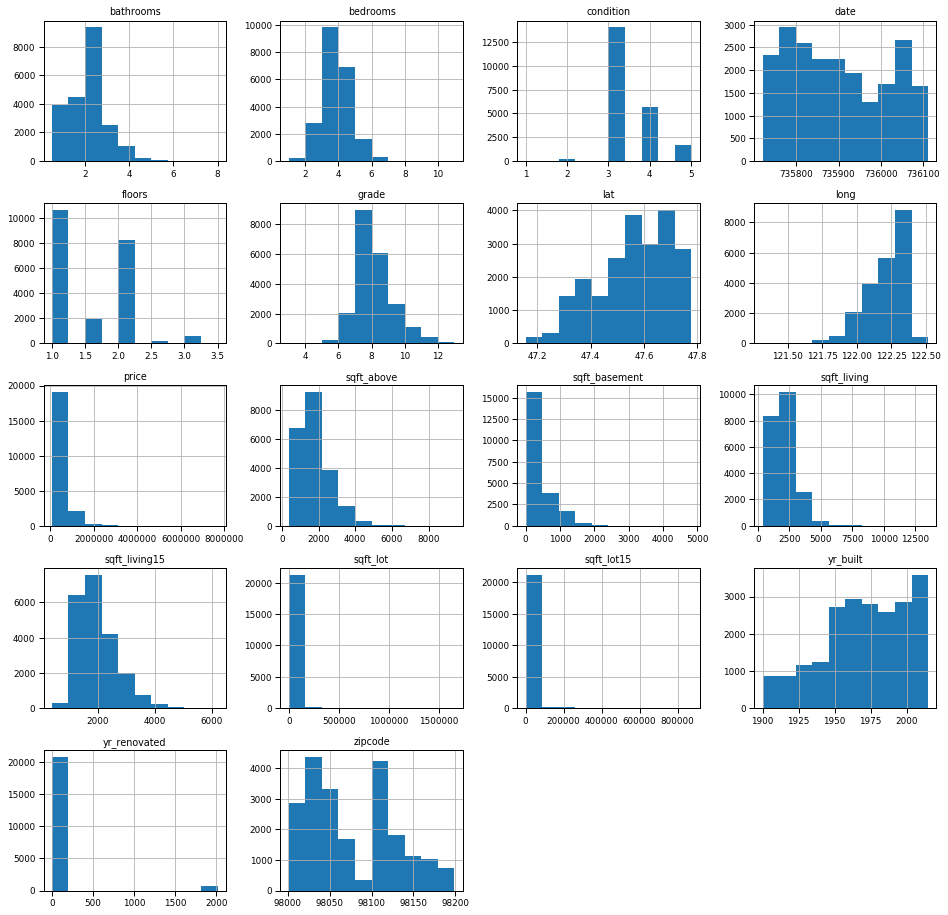

In [19]:
# Check out feature distributions
df.hist(figsize=(16,16));

We can see that condition and grade are technically categorical, but since they're on a scale I'm going to treat them as continuous. 

Most of the data are skewed, so we will log transform and since we're log transforming, we won't be able to get an exact estimate of price. Since I want to know which variables or features have the greatest influence on price, I will min-max scale as well and compare the coefficients. 

And since sqft_basement and yr_renovated are combined continuous, but also sort of binary since some have the feature and some don't, I'm going to bin these and drop the first bin of '0' for one-hot encoding.

# Exploratory Analysis

## Price vs. Sqft Basement
I'm curious to see if there is a relationship between sqft_basement and price.

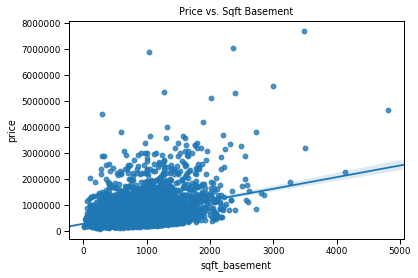

In [20]:
# Regression plot for all homes with basements

sns.regplot(df[df.sqft_basement > 0].sqft_basement,df[df.sqft_basement > 0].price)
plt.title('Price vs. Sqft Basement');

We can see there does appear to be a relationship between the size of a home's basement and its selling price. This makes sense intuitively as larger homes will on average I imagine have larger basements. We could confirm this with plots of sqft_living vs. sqft_basement and price vs. sqft_living. So let's go ahead and do that. 

## Sqft Living vs. Sqft Basement

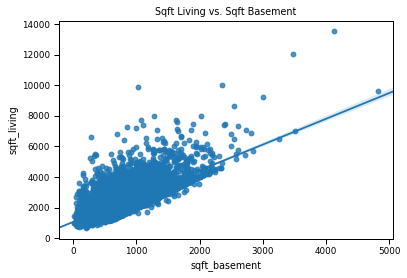

In [21]:
# sqft_living vs. sqft_basement for homes with basements

sns.regplot(df[df.sqft_basement > 0].sqft_basement,df[df.sqft_basement > 0].sqft_living)
plt.title('Sqft Living vs. Sqft Basement');

Confirmed. And now price vs. sqft_living.

## Price vs. Sqft Living

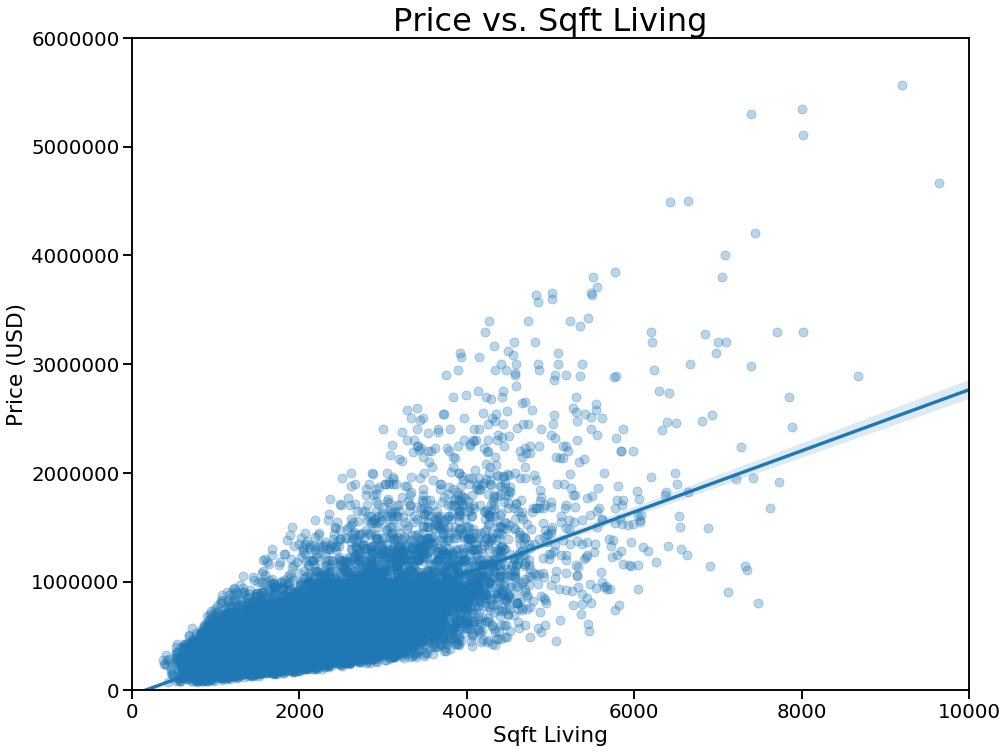

In [22]:
# Regression plot for price vs. sqft_living

# Set style to 'talk' for outputting figure 
sns.set_context("talk", font_scale=1.2)

# Set figure size
plt.figure(figsize=(15,12))

# Plot
sns.regplot(df.sqft_living,df.price,scatter_kws={'alpha':0.3})

# Title & lables
plt.title('Price vs. Sqft Living',fontsize=32)
plt.xlabel('Sqft Living')
plt.ylabel('Price (USD)')

# Zoom in for scale
plt.xlim((0,10000))
plt.ylim((0,6000000))

# Output and save figure
plt.savefig('price_vs_sqft_living.png', bbox_inches='tight')

Confirmed again. This makes intuitive sense. Also, these data appear to be heteroscedastic. We will be log transforming them to meet the heteroskedasticity assumption. 

## Price vs. Year Renovated
Now let's take a look at the relationship between year renovated and price.

(0, 4000000)

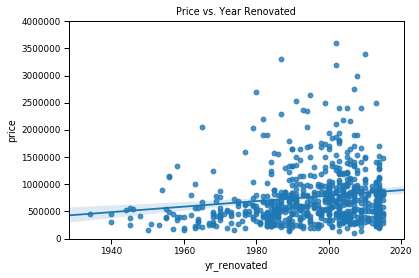

In [23]:
# Regression plot for all homes that have been renovated

# Set style so output is 'paper' size
sns.set_context("paper")

# Plot
fig = sns.regplot(df.yr_renovated[df.yr_renovated > 0],df.price[df.yr_renovated > 0])
plt.title('Price vs. Year Renovated');

# Zoom in for scale
plt.ylim((0,4000000))

We can see there does appear to be a slight linear relationship between the price of a home  and the year it was renovated. There are some major outliers here. If we zoom in to about \\$2M to \\$4M we can see it a little bit better. It's still only slight though. Most likely this is due to the influence of other features such as grade, sqft_living, bathrooms, etc. 

## Price vs. Grade

I looked up the King County Grading system to see what grade represents. Basically grade 1-5 falls short of bulding code, 6 meets code, 7 is average, and 13 represents mansion level. This was the plot I was most looking forward to seeing. Let's take a look at the relationship between grade and price.

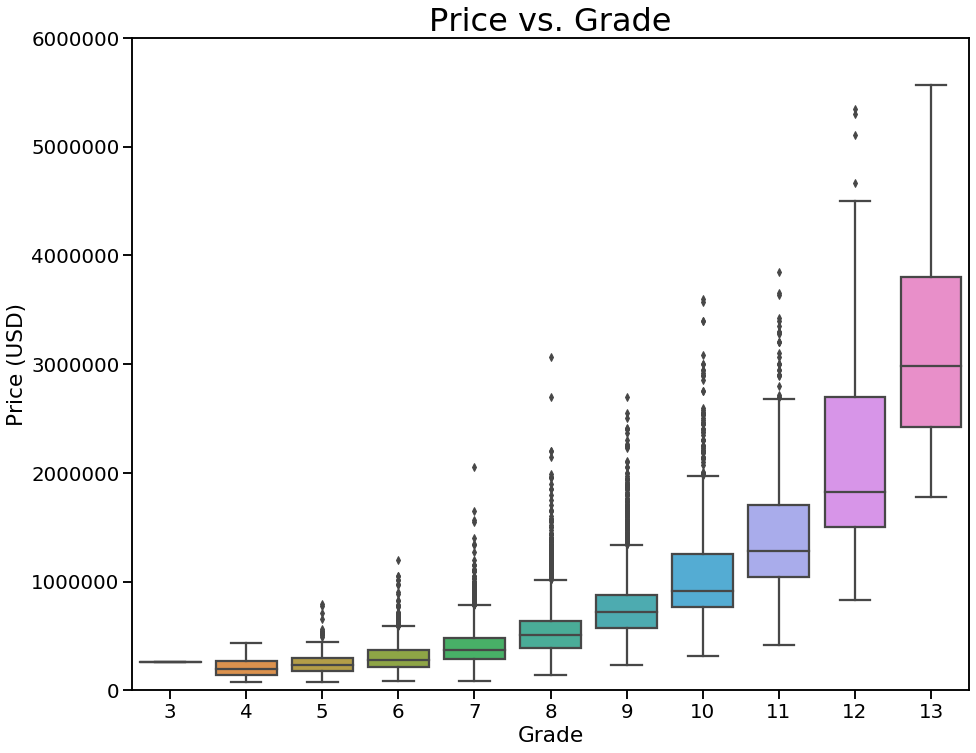

In [24]:
# Use box plot to see the relationship between grade & price

# Set style to 'talk' for outputting figure 
sns.set_context("talk", font_scale=1.2)

# Set figure size
plt.figure(figsize=(15,12))

# Plot data & add labels
fig = sns.boxplot(x='grade', y='price', data=df)
plt.title('Price vs. Grade',fontsize=32)
plt.xlabel('Grade')
plt.ylabel('Price (USD)');

# Set ymax to $6M for viewing. There are a few outliers up to around $8M.
fig.axis(ymin=0, ymax=6000000);

# Output and save figure
plt.savefig('price_vs_grade.png', bbox_inches='tight')

We can see there is a definite relationship here between grade and price. It appears to be exponential. This feature could be added as a polynomial feature, but to start I'm going to leave it linear and see how the model does. 

The link to the grading scale can be found here: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r.

## Price vs. Condition

I looked up the King County Grading system to see what condition represents. Condition 3 is average. Less than 3 would require repairs. 4 is good, showing regular wear, but no repairs needed. Condition 5 is very good, upgrades have been made or home is new. 

I imagine this would have a relationship with the price as well. 

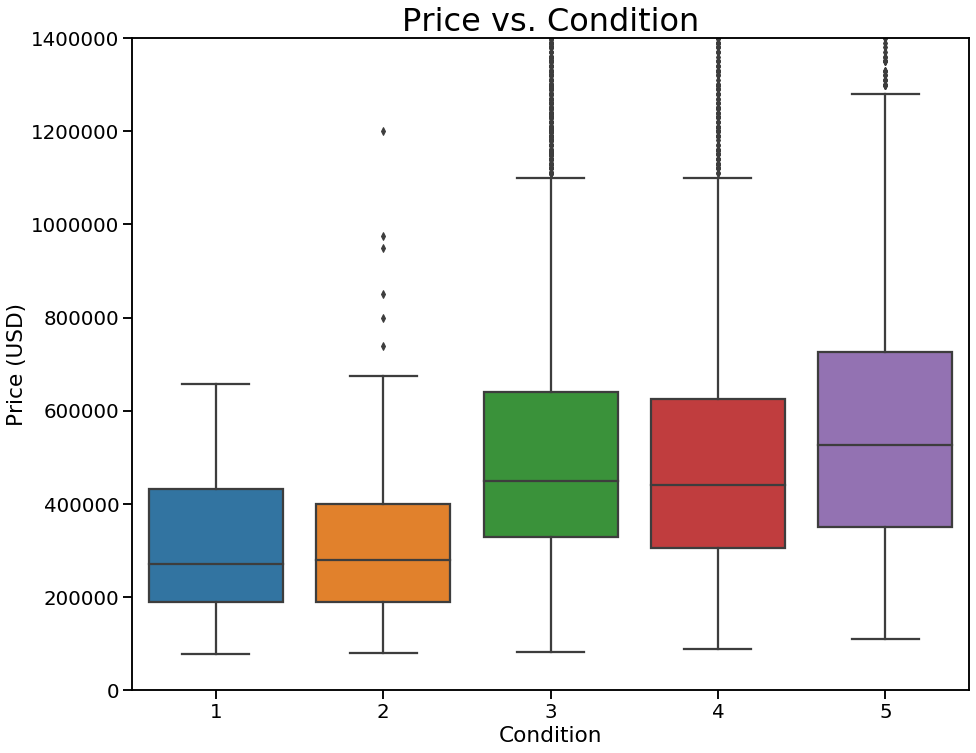

In [25]:
# Use box plot to see the relationship between condition & price

# Set figure size
plt.figure(figsize=(15,12))

# Plot data & add labels
fig = sns.boxplot(x='condition', y='price', data=df)
plt.title('Price vs. Condition',fontsize=32)
plt.xlabel('Condition')
plt.ylabel('Price (USD)');

# Set ymax to $1.4M for optimal viewing
fig.axis(ymin=0, ymax=1400000);

# Output and save figure
plt.savefig('price_vs_condition.png', bbox_inches='tight')

While there does appear to be an increase in price with each level of condition, we can see there are a lot of outliers. This is most likely due to the more expensive homes being at large home or mansion level, as we can see with condition 3, average having homes up to around \\$7M and condition 4, good with regular wear having prices up to $8M. This would include interaction with other features such as grade, square foot living, number of bedrooms, etc.


The link to the condition scale can be found here: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r.

## Price vs. Bedrooms

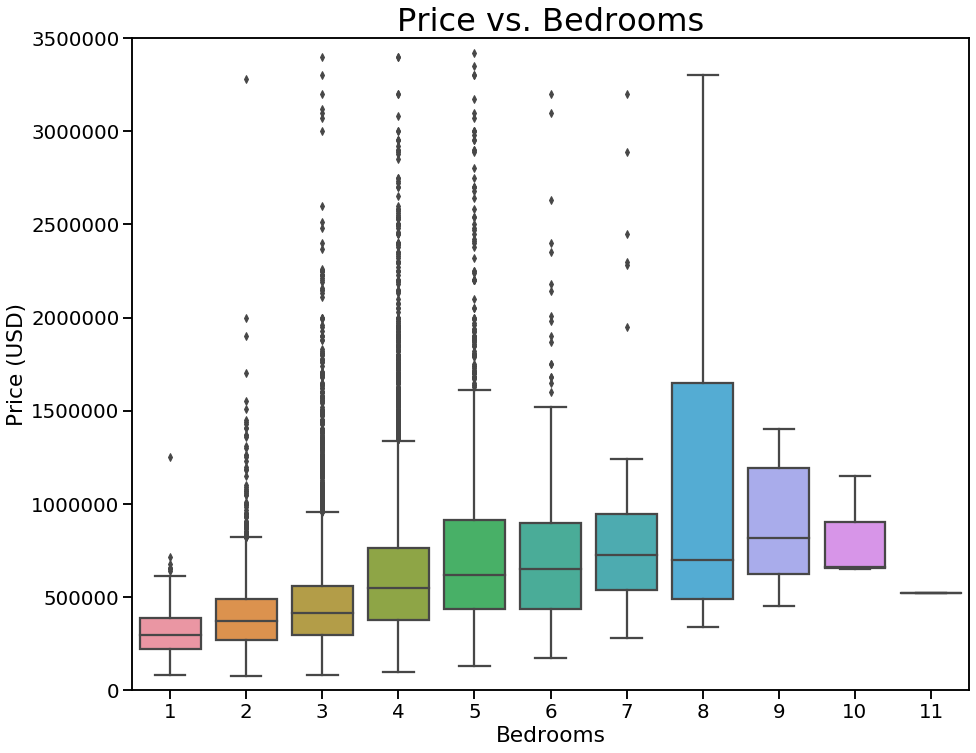

In [26]:
# Use box plot to see the relationship between bedrooms & price

# Set figure size
plt.figure(figsize=(15,12))

# Plot data & add labels
fig = sns.boxplot(x='bedrooms', y='price', data=df)
plt.title('Price vs. Bedrooms',fontsize=32)
plt.xlabel('Bedrooms')
plt.ylabel('Price (USD)');

# Set ymax to $3.5M for optimal viewing
fig.axis(ymin=0, ymax=3500000);

# Output and save figure
plt.savefig('price_vs_bedrooms.png', bbox_inches='tight')

There does appear to be a very slight relationship. There are most likely other features playing a role such as square feet of living space, grade, condition, etc.  

## Price vs. Bathrooms

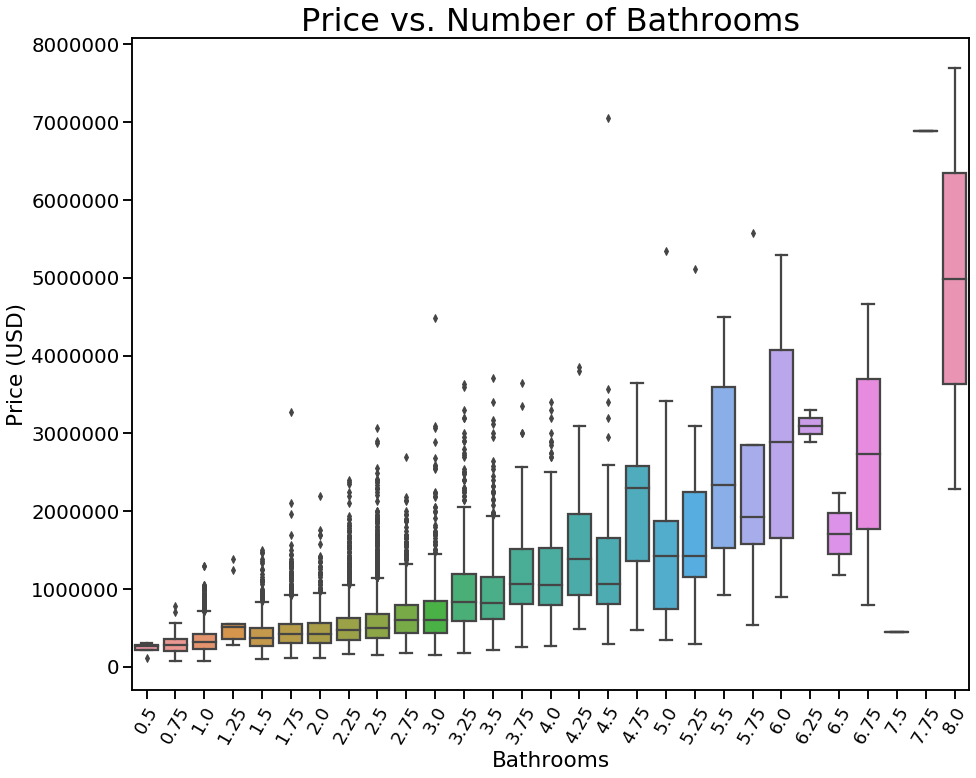

In [27]:
# Use box plot to see the relationship between bathrooms & price

# Set figure size
plt.figure(figsize=(15,12))

# Plot data & add labels
fig = sns.boxplot(x='bathrooms', y='price', data=df)
plt.title('Price vs. Number of Bathrooms',fontsize=32)
plt.xlabel('Bathrooms')
plt.ylabel('Price (USD)')
plt.xticks(fontsize=18, rotation=60);

# Output and save figure
plt.savefig('price_vs_bathrooms.png', bbox_inches='tight')

We can see a pretty clear linear (and possibly slightly exponential) relationship here between price and bathrooms. Another thing to not as far as outliers are concerned is that there are homes in this data set on the lower end with only a half bathroom. That means the home only has a toilet and sink, or a toilet and shower, but no sink or tub. This would most likely be a very small or old home. We can look into this more when we get to feature engineering. 

# Feature Engineering

- Check for and remove extreme outliers in the data
- One-hot encode binned data (as categorical data are on a scale and being treated as continuous)
- Normalize to account for skewness and heteroskedasticity in the data and get all features on the same scale to compare coefficients

## Remove Extreme Outliers

We could see during the EDA and data cleaning that there were some extreme outliers when it came to price and square feet of the lot. These are the mansion level homes. So, we're going to take a closer look at the upper and lower percentiles here to remove the extreme outliers. 

In [28]:
# Percentiles for price

# Define percentiles
percentiles = [0,1,99,100]

# Print them out
for i in percentiles:
    q = i/100
    print("{} percentile price: {}".format(q, df.price.quantile(q=q)))
    
# Percentiles for sqft_lot

# Print them out
for i in percentiles:
    q = i/100
    print("{} percentile sqft_lot: {}".format(q, df.sqft_lot.quantile(q=q)))

0.0 percentile price: 78000.0
0.01 percentile price: 154000.0
0.99 percentile price: 1970000.0
1.0 percentile price: 7700000.0
0.0 percentile sqft_lot: 520.0
0.01 percentile sqft_lot: 1013.9499999999999
0.99 percentile sqft_lot: 213008.0
1.0 percentile sqft_lot: 1651359.0


In [29]:
# Remove extreme outliers in the lower and upper 1%

# Get original length to see percent removed
orig_tot = len(df)

# Subset to remove extreme outliers
# Price
df = df[(df.price >= 154000.0) & (df.price <= 1970000.0)] 
# Sqft lot
df = df[(df.sqft_lot >= 1013) & (df.sqft_lot <= 213008.0)]

# Calculate percent removed
print('Percent removed:', (orig_tot -len(df))/orig_tot)

Percent removed: 0.0394517503241341


I also did this for bathrooms, but found that the model performed better when I did not remove extreme outliers for numbers of bathrooms. Therefore, I kept all remaining data points after the above removals. 

Total percent of the data removed is just under 4%, which makes sense since we removed the top and bottom percent for two features. They had just a slight overlap with each other. (About 0.5%) 

## One-Hot Encode

Let's bin and one-hot encode sqft_basement and yr_renovated.

In [30]:
# Get quartile cuts for homes with a basement

bins = pd.qcut(df.sqft_basement[df.sqft_basement > 0],q=4)
bins.value_counts()

(9.999, 450.0]     2047
(450.0, 700.0]     2035
(960.0, 3260.0]    1983
(700.0, 960.0]     1914
Name: sqft_basement, dtype: int64

In [31]:
# Bin sqft_basement

bins_sqft_basement = [0,10,450,980,5000]

# Define function to return dummies
def binned_dummies(data, features, bins):
    data_bins = pd.cut(data, bins)
    data_bins = data_bins.cat.as_unordered()
    dummies = pd.get_dummies(data_bins, prefix = features, drop_first=True)
    return dummies

dummies_sqft_basement = binned_dummies(df.sqft_basement,'sqft_basement', bins_sqft_basement)

# Remove original column from data set
df = df.drop(['sqft_basement'], axis=1)
                                            
# Add new columns in
df = pd.concat([df, dummies_sqft_basement], axis=1)

Let's do the same for yr_renovated.

In [32]:
# Get quartile cuts for homes that have been renovated

bins = pd.qcut(df.yr_renovated[df.yr_renovated > 0],q=4)
bins.value_counts()

(1987.0, 2000.0]      191
(1933.999, 1987.0]    181
(2008.0, 2015.0]      166
(2000.0, 2008.0]      166
Name: yr_renovated, dtype: int64

In [33]:
# Bin 'yr_renovated'

bins_yr_renovated = [0,1933,1987,2000,2008,2015]

dummies_yr_renovated = binned_dummies(df.yr_renovated,'yr_renovated', bins_yr_renovated)

# Remove original column from data set
df = df.drop(['yr_renovated'], axis=1)
                                            
# Add new columns in
df = pd.concat([df, dummies_yr_renovated], axis=1)

## Normalize & Scale

Normalize data by log transforming, normalizing and min-max scaling. We're doing this to meet the normal assumption as many of our features have skewed data. 

When I made my first model without transforming as I wanted to preserve the ability to see direct impact of coefficients on price, even though the features themselves did not meet the normality assumption. However, even after removing outliers, the model's residuals were not normally distributed and did not meet the normality assumption. This was apparent with a Q-Q plot of the residuals. 

For this reason I log-transformed, normalized and scaled all of the features. The trade off was not having an exact output for price. We still get to see which features have the greatest impact on price, which is applicable for focusing on a strategy for stakeholders. 

In [34]:
# Normalize & Scale Continuous Features

# Continuous features
features = ['date','price','sqft_living','lat','long','bedrooms',
            'bathrooms','floors','condition','grade','sqft_lot',
            'sqft_above','yr_built','sqft_living15','sqft_lot15',
            'zipcode']

df_cont_features = df[features]

### Log transform ###

df_log = np.log(df_cont_features)
#df_log.columns = log_names


### Normalize ###

# Define function to normalize
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# Apply function to normalize
df_log_norm = df_log.apply(normalize)

### Min-Max Scale ###

# Get everything on the same scale 0 to 1
# Define function to min-max scale
def minmaxscale(feature):
    return (feature-min(feature))/(max(feature)-min(feature))

# Apply function to min-max scale
df_log_norm_scale = df_log.apply(minmaxscale)

# Remove original column from data set
df = df.drop(features, axis=1)

# Add new columns in
df = pd.concat([df, df_log_norm_scale], axis=1) 

In [35]:
# Take a look to see everything is scaled 0 to 1
df.describe()

,"sqft_basement_(10, 450]","sqft_basement_(450, 980]","sqft_basement_(980, 5000]","yr_renovated_(1933, 1987]","yr_renovated_(1987, 2000]","yr_renovated_(2000, 2008]","yr_renovated_(2008, 2015]",date,price,sqft_living,...,bathrooms,floors,condition,grade,sqft_lot,sqft_above,yr_built,sqft_living15,sqft_lot15,zipcode
count,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,...,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000,20744.000000
mean,0.098583,0.195093,0.090870,0.008725,0.009207,0.008002,0.008002,0.461714,0.430658,0.540877,...,0.505328,0.265576,0.752999,0.630059,0.383175,0.493321,0.619934,0.579605,0.379278,0.388831
std,0.298108,0.396281,0.287431,0.093004,0.095515,0.089099,0.089099,0.289786,0.190319,0.134866,...,0.142315,0.278817,0.111919,0.097762,0.150673,0.138282,0.253590,0.119765,0.114901,0.270016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.207736,0.292965,0.449217,...,0.462607,0.000000,0.682606,0.577833,0.301140,0.392396,0.450745,0.495064,0.316497,0.161753
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428270,0.420700,0.544318,...,0.555410,0.323657,0.682606,0.577833,0.376384,0.479897,0.650180,0.571440,0.377830,0.323453
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.746204,0.557968,0.635522,...,0.594316,0.553295,0.861353,0.668898,0.436824,0.593028,0.838782,0.662900,0.420025,0.591153
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Check for Multicollinearity 

Let's take a look at our continuous features to check for multicollinearity. I prefer to look at a boolean correlation matrix so I can easily search for instances of 'True' in a column as I find that easier to look at than a heatmap.  So we're doing to take a look here. 

In [36]:
# Take a look at the correlation matrix to check for multicollinearity
# exclude one-hot-encoded features as the first category for each was 
# already removed to prevent multicollinearity

abs(df[features].corr()) > 0.75

,date,price,sqft_living,lat,long,bedrooms,bathrooms,floors,condition,grade,sqft_lot,sqft_above,yr_built,sqft_living15,sqft_lot15,zipcode
date,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False
lat,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
long,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


We can see here that 'sqft_living' seems to be strongly correlated with 'bathrooms' and 'sqft_above'. We could remove 'sqft_living' due to multicollinearity, however since it represents the square footage of the entire home and seems that it would be a strong indicator of home price, for now we'll go ahead and keep it. It can always be removed to see its effect on the model. 

We have some nearest neighbor features here as well (denoted with an appended '15') which exibit colinearity. Let's take a look at those. 

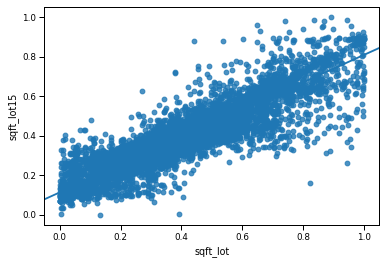

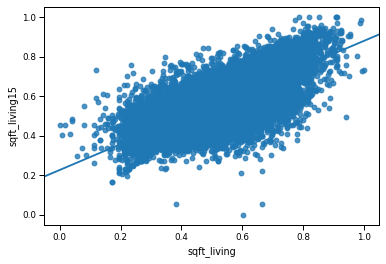

In [37]:
# Check & see if sqft_lot15 & sqft_living15 are correlated with sqft_lot & sqft_living
sns.set_context("paper")
sns.regplot(df.sqft_lot,df.sqft_lot15)
plt.show()
sns.regplot(df.sqft_living,df.sqft_living15)
plt.show()

We can see that 'sqft_lot15' & 'sqft_living15' are correlated with 'sqft_lot' & 'sqft_living' respectively. This makes sense as the features appended with 15 represent the average of the 15 nearest neighbors and it indicates a neighborhood effect in home sale prices. 

We will see if these are significant in our model, and if need be remove the features at that point. Nearest neighbors are a strong predictor when it comes to home sale prices in neighborhoods, so it may be a good feature to keep.

# Start Modeling

## Separate Target & Feature Variables

In [38]:
# Separate target and feature variables

# Features
X = df.drop(['price'],axis=1)
# Target
y = df.price

## Model First with Scikit Learn

In [39]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split data with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [40]:
# Fit Model & Calculate Predictions

# Import Packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

# Initialize the linear regression model class
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

# Calculate predictions on test set
y_hat_test = linreg.predict(X_test)

# Calculate RMSE of test set
test_mse = mean_squared_error(y_test, y_hat_test)

# Assign coefficients & intercept
intercept=linreg.intercept_
coefficients=linreg.coef_

# Output y-int, coeffs & RMSE of the test set
print(f"y-int: {intercept}")
print(f"coeffs: {coefficients}")
print(f"MSE test: {test_mse}")

y-int: -0.605110554776578
coeffs: [ 0.02861674  0.02817831  0.05104978 -0.0145443   0.03981281  0.05259015
  0.0651124   0.02854454  0.21125455  0.32281232  0.04253286 -0.1270195
  0.08759649  0.04709088  0.13540494  0.6952817   0.0216432   0.21267859
 -0.18163468  0.28572672 -0.09713742 -0.03030351]
MSE test: 0.00942533397903363


## Cross-validate Model

We will use our 'baseline_R2' variable produced here later on when we search for top interactions between features.

In [41]:
# Cross-validate & Output RMSE & R^2 

# Import Packages
from sklearn.model_selection import cross_val_score

# Cross-validate Model

# Test Errors
mse = make_scorer(mean_squared_error)
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
print(f"Crossval MSE: {cv_5_results.mean()}")

# R-squared
from sklearn.model_selection import KFold
crossval = KFold(n_splits=10, shuffle=True, random_state=1)
baseline_R2 = np.mean(cross_val_score(linreg, X, y, scoring='r2', cv=crossval))
print(f"Baseline R^2: {baseline_R2}")

Crossval MSE: 0.009539857759726182
Baseline R^2: 0.7384174752070203


## Now Model with OLS

## Model 1: All Features w/o Interactions

In [42]:
# Fit Model & Output Regression Results Summary

# Import Package
import statsmodels.api as sm
from statsmodels.api import add_constant

# Build Model
X = sm.add_constant(X)
model1 = sm.OLS(y,X)
results1 = model1.fit()

# MSE of the residuals
print(f"MSE: {results1.mse_resid}")

# Output Results
results1.summary()

MSE: 0.00944636844239309


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     2673.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        15:57:07   Log-Likelihood:                 18933.
No. Observations:               20744   AIC:                        -3.782e+04
Df Residuals:                   20721   BIC:                        -3.764e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.6074      0.011    -56.628      0.000      -0.628      -0.586
sqft_basement_(10, 450]       0.0318      0.003     10.831      0.000       0.026       0.038
sqft_basement_(450, 980]      0.0302      0.004      7.694      0.000       0.023       0.038
sqft_basement_(980, 5000]     0.0553      0.005     10.269      0.000       0.045       0.066
yr_renovated_(1933, 1987]    -0.0133      0.007     -1.803      0.071      -0.028       0.001
yr_renovated_(1987, 2000]     0.0414      0.007      5.762      0.000       0.027       0.056
yr_renovated_(2000, 2008]     0.0592      0.008      7.667      0.000       0.044       0.074
yr_renovated_(2008, 2015]     0.0559      0.008      7.263      0.000       0.041       0.071
date                          0.0290      0.002     12.422      0.000       0.024       0.034
sqft_living                   0.2037      0.028      7.302      0.000       0.149       0.258
lat                           0.3226      0.003     97.999      0.000       0.316       0.329
long                          0.0449      0.008      5.657      0.000       0.029       0.060
bedrooms                     -0.1253      0.008    -15.938      0.000      -0.141      -0.110
bathrooms                     0.0851      0.009      9.868      0.000       0.068       0.102
floors                        0.0457      0.004     11.871      0.000       0.038       0.053
condition                     0.1311      0.007     19.450      0.000       0.118       0.144
grade                         0.6957      0.012     58.039      0.000       0.672       0.719
sqft_lot                      0.0089      0.011      0.777      0.437      -0.014       0.031
sqft_above                    0.2211      0.026      8.583      0.000       0.171       0.272
yr_built                     -0.1810      0.004    -43.865      0.000      -0.189      -0.173
sqft_living15                 0.2881      0.009     30.822      0.000       0.270       0.306
sqft_lot15                   -0.0790      0.015     -5.401      0.000      -0.108      -0.050
zipcode                      -0.0333      0.003    -10.352      0.000      -0.040      -0.027
==============================================================================
Omnibus:                      524.744   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              879.962
Skew:                           0.231   Prob(JB):                    8.29e-192
Kurtosis:                       3.897   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see here that 'sqft_lot' and 'yr_renovated_(1933, 1987]'are not significant. We're going to remove these and then rerun our model.

In [43]:
# Drop high p-value variables
X = X.drop(['sqft_lot','yr_renovated_(1933, 1987]'], axis=1)

In [44]:
# Build Model 1

X = sm.add_constant(X)
model = sm.OLS(y,X)
results1b = model.fit()

# MSE of the residuals
print(f"MSE: {results1b.mse_resid}")

results1b.summary()

MSE: 0.009447218627740122


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     2940.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        15:57:07   Log-Likelihood:                 18931.
No. Observations:               20744   AIC:                        -3.782e+04
Df Residuals:                   20723   BIC:                        -3.765e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.6084      0.011    -56.856      0.000      -0.629      -0.587
sqft_basement_(10, 450]       0.0317      0.003     10.814      0.000       0.026       0.037
sqft_basement_(450, 980]      0.0302      0.004      7.684      0.000       0.022       0.038
sqft_basement_(980, 5000]     0.0553      0.005     10.261      0.000       0.045       0.066
yr_renovated_(1987, 2000]     0.0418      0.007      5.824      0.000       0.028       0.056
yr_renovated_(2000, 2008]     0.0595      0.008      7.716      0.000       0.044       0.075
yr_renovated_(2008, 2015]     0.0562      0.008      7.302      0.000       0.041       0.071
date                          0.0291      0.002     12.435      0.000       0.024       0.034
sqft_living                   0.2044      0.028      7.326      0.000       0.150       0.259
lat                           0.3226      0.003     98.121      0.000       0.316       0.329
long                          0.0445      0.008      5.627      0.000       0.029       0.060
bedrooms                     -0.1248      0.008    -15.886      0.000      -0.140      -0.109
bathrooms                     0.0845      0.009      9.799      0.000       0.068       0.101
floors                        0.0449      0.004     11.848      0.000       0.037       0.052
condition                     0.1314      0.007     19.528      0.000       0.118       0.145
grade                         0.6959      0.012     58.074      0.000       0.672       0.719
sqft_above                    0.2216      0.026      8.620      0.000       0.171       0.272
yr_built                     -0.1802      0.004    -44.363      0.000      -0.188      -0.172
sqft_living15                 0.2881      0.009     30.835      0.000       0.270       0.306
sqft_lot15                   -0.0696      0.008     -9.200      0.000      -0.084      -0.055
zipcode                      -0.0333      0.003    -10.368      0.000      -0.040      -0.027
==============================================================================
Omnibus:                      522.619   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              873.909
Skew:                           0.231   Prob(JB):                    1.71e-190
Kurtosis:                       3.893   Cond. No.                         129.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looks good. Our p-values are all significant. Now let's take a look at the residuals and the coefficients. We're going to define some functions to see if the residuals meet the normality and homoskedasticity assumptions, and to plot our coefficients as well.

### Q-Q Plot of the Model Residuals

Test for normality assumption.

In [45]:
# Q-Q Plot

# Define function 
def qqplot(results):
    '''
    Takes in OLS Regression Results and outputs q-q plot 
    of the model residuals.
    '''
    sns.set_context("paper")
    fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)
    plt.title('Q-Q Plot of the Residuals')
    return plt.show()

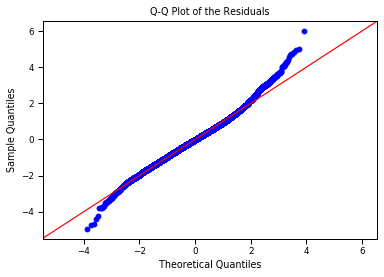

In [46]:
qqplot(results1b)

Looks good. We previously removed extreme outliers during the cleaning of the data and log-transformed our data. There may be some some outliers that we can see here. For now it looks good though, we'll continue. 

### Residuals vs. Fitted Plot 

Test for heteroskedasticity.

In [47]:
# Plot model residuals vs. fitted to test for heteroskedasticity

def heterosk(results):
    '''
    Takes in results from the fitted model and outputs a plot 
    of the residuals vs. the fitted values. 
    '''
    sns.set_context("paper")
    plt.scatter(results.fittedvalues, results.resid, alpha=0.5,s=5)
    plt.plot(results.fittedvalues, [0 for i in range(len(results.fittedvalues))])
    plt.ylabel('Residuals')
    plt.xlabel('Fitted')
    plt.title('Residuals vs. Fitted');
    return plt.show()

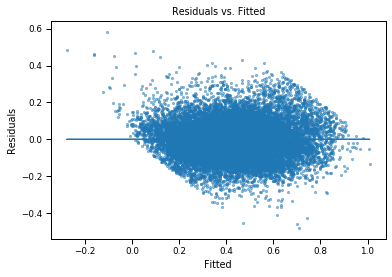

In [48]:
heterosk(results1b)

Appears to exhibit homoskedasticity (same on top and bottom) rather than heteroskedasticity (the funnel type shape). Looks good. 

### Plot of the Coefficients

Plot the coefficients with their respective 95% confidence intervals. 

In [49]:
# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    plt.savefig(f'Model_Coeffs{coef_df.coef.max()}.png', bbox_inches='tight');
    return plt.show()

Let's check out the residuals. I'm excited to see which coefficients have the greatest effect on the price of a house. (The highest coefficient that is.)

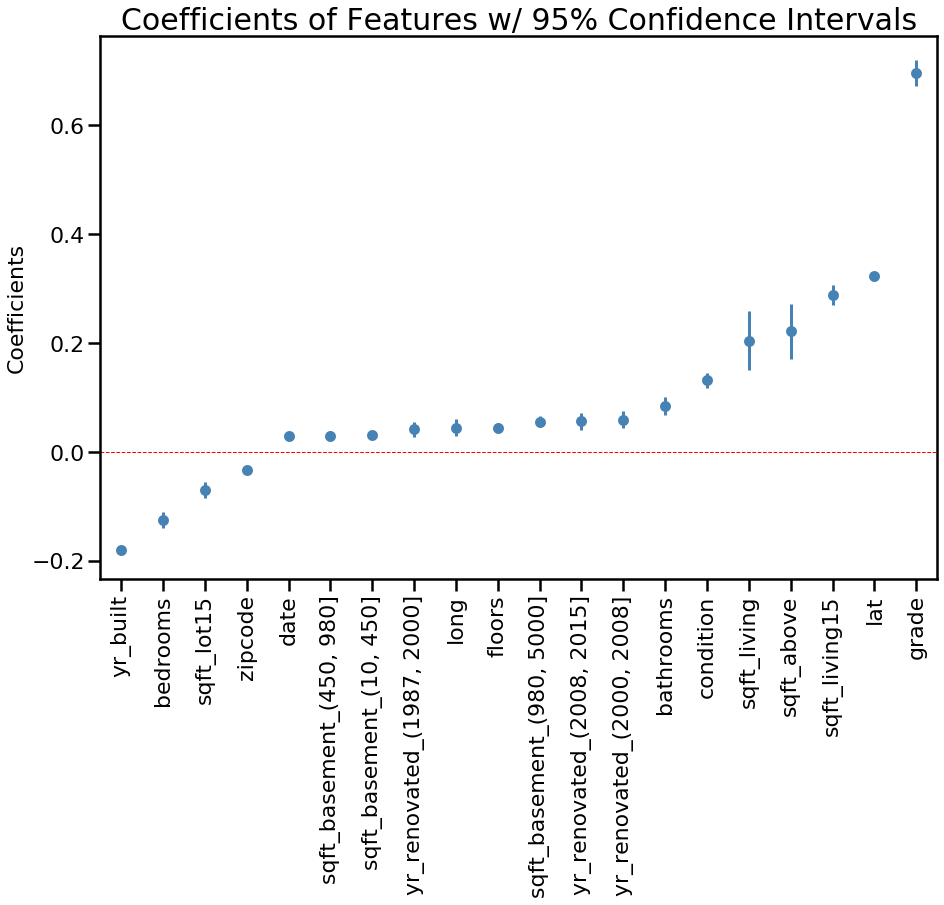

In [50]:
# Plot coefficients w/95% confidence intervals for Model 1

coefplot(results1b)

As we had a hunch about earlier, grade has emerged as the leader in effect on home sale price. This makes sense as higher grade is more of a luxury home and we could see the relationship appeared to be slightly exponential. 

We can also see sqft_above emerging as a leader. This feature represents the square footage of the home not including the square footage of the basement. So this is essentially the true living space. 

Next we'll take a look at the interactions between our feature variables to see if there are any interactions going on that better predict price than the features alone.

### Interactions

Top 5 interactions. 

In [51]:
# Import package we'll be using
from itertools import combinations

# Find top interactions using R^2 value

# Use combinations from itertools to create all possible combinations of two features
feat_combinations = combinations(X_train.columns, 2)

# Initiate empty list to fill for interactons values
interactions = []

# for i, (feature1,feature2) in feature_combinations:
for i, (a, b) in enumerate(feat_combinations):
    
    # fill interatctions list with feature a * feature b
    X_train['interaction'] = X_train[a] * X_train[b]
    
    # Calculate R^2
    R2 = np.mean(cross_val_score(linreg, X_train, y_train, scoring='r2', cv=crossval))
    
    # See if it's higher than our R2 value we calculated above during crossvalidation 
    if R2 > baseline_R2:
        
        # If it is higher, append to our list
        interactions.append((a, b, round(R2,5)))

# Print out the top 5 interactions
print('Top 5 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:5])

Top 5 interactions: [('sqft_living', 'grade', 0.7449), ('bathrooms', 'grade', 0.74402), ('sqft_living', 'bathrooms', 0.74325), ('lat', 'sqft_lot15', 0.74302), ('long', 'zipcode', 0.74272)]


We can see here that the top 3 interactions are all between sqft_living, grade, and bathrooms. This is affirming as we could see in our EDA that these three each appeared to have strong relationships with price.

"Top 3 interactions: [('sqft_living', 'grade', 0.74664), ('bathrooms', 'grade', 0.7455), ('sqft_living', 'bathrooms', 0.74479)]". Each time we run this model, sometimes the 3rd one switches, but this is the one that outputs the most, so we're going to go ahead with these three.

Let's add these interactions into our model one at a time to see how they affect the R^2 and MSE values of our model. 

## Model 2: All Features w/Top Interaction

In [52]:
#Build a final model with interactions

final = X.copy()

final['sqft_living*grade'] = final['sqft_living'] * final['grade']

The model performed the best with just the top interaction added. The R^2 was slightly higher and the MSE was slightly lower with each added/all three added. However, the best predictor when it came to the the coefficient plots by measure of the smallest confidence intervals was the model with only the top interaction added.  

In [53]:
# Build Model 2

final = sm.add_constant(final)
model = sm.OLS(y,final)
results2 = model.fit()

# MSE of the residuals
print(f"MSE: {results2.mse_resid}")

results2.summary()

MSE: 0.00914299930863877


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     2926.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        15:57:46   Log-Likelihood:                 19271.
No. Observations:               20744   AIC:                        -3.850e+04
Df Residuals:                   20722   BIC:                        -3.832e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.2303      0.018    -12.918      0.000      -0.265      -0.195
sqft_basement_(10, 450]       0.0306      0.003     10.596      0.000       0.025       0.036
sqft_basement_(450, 980]      0.0223      0.004      5.755      0.000       0.015       0.030
sqft_basement_(980, 5000]     0.0346      0.005      6.453      0.000       0.024       0.045
yr_renovated_(1987, 2000]     0.0469      0.007      6.636      0.000       0.033       0.061
yr_renovated_(2000, 2008]     0.0596      0.008      7.854      0.000       0.045       0.074
yr_renovated_(2008, 2015]     0.0591      0.008      7.804      0.000       0.044       0.074
date                          0.0289      0.002     12.556      0.000       0.024       0.033
sqft_living                  -0.3901      0.036    -10.970      0.000      -0.460      -0.320
lat                           0.3231      0.003     99.888      0.000       0.317       0.329
long                          0.0470      0.008      6.029      0.000       0.032       0.062
bedrooms                     -0.0969      0.008    -12.430      0.000      -0.112      -0.082
bathrooms                     0.0974      0.008     11.464      0.000       0.081       0.114
floors                        0.0433      0.004     11.614      0.000       0.036       0.051
condition                     0.1400      0.007     21.128      0.000       0.127       0.153
grade                         0.0564      0.027      2.085      0.037       0.003       0.109
sqft_above                    0.1227      0.026      4.797      0.000       0.073       0.173
yr_built                     -0.1711      0.004    -42.655      0.000      -0.179      -0.163
sqft_living15                 0.2604      0.009     28.147      0.000       0.242       0.279
sqft_lot15                   -0.0956      0.008    -12.740      0.000      -0.110      -0.081
zipcode                      -0.0365      0.003    -11.542      0.000      -0.043      -0.030
sqft_living*grade             1.1181      0.043     26.278      0.000       1.035       1.202
==============================================================================
Omnibus:                      438.709   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              706.630
Skew:                           0.206   Prob(JB):                    3.61e-154
Kurtosis:                       3.805   Cond. No.                         204.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All features are significant. Looks good.

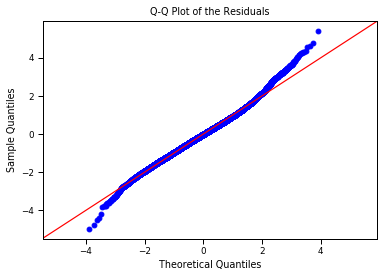

In [54]:
# Plot q-q for Model 2 residuals
qqplot(results2)

Residuals are normally distributed. Looks good.

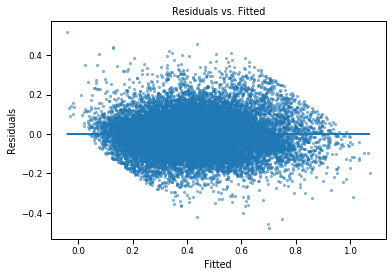

In [55]:
# Plot residuals vs fitted for Model 2 residuals
heterosk(results2)

Residuals look pretty homoskedastic. Looks good. 

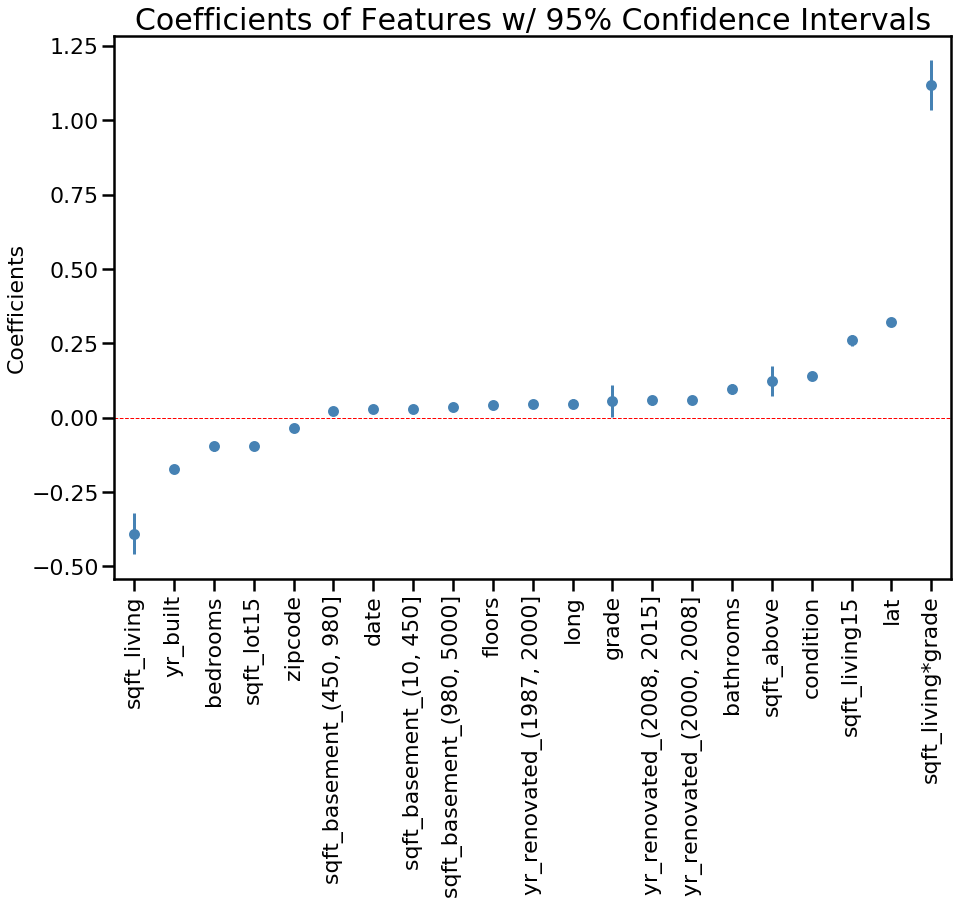

In [56]:
# Plot coefficients w/95% confidence intervals for Model 2
coefplot(results2)

How beaufitul is this coefficient plot? We can see the top predicting feature or the feature with the greatest impact on price is the interaction of square feet of living space and grade. This is followed by latitude and average square feet of the 15 nearest neighbors, which indicates a neighborhood effect. 

## Model 3: All Features w/Top 3 Interactions

Since the top 3 interactions were all so close to each other in R^2 values, I'm curious to see how the Model performs with all 3, and if we can gain any additional insights with the resulting coefficients.

In [57]:
# Add 2nd & 3rd ranked interactions

final['bathrooms*grade'] = final['bathrooms'] * final['grade']
final['sqft_living*bathrooms'] = final['sqft_living'] * final['bathrooms']

In [67]:
# Build Model 3

final_const = sm.add_constant(final)
model = sm.OLS(y,final_const)
results3 = model.fit()

# MSE of the residuals
print(f"MSE: {results3.mse_resid}")

results3.summary()

MSE: 0.009168994820416016


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     3222.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        16:52:15   Log-Likelihood:                 19240.
No. Observations:               20744   AIC:                        -3.844e+04
Df Residuals:                   20724   BIC:                        -3.828e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.2407      0.019    -12.987      0.000      -0.277      -0.204
yr_renovated_(1987, 2000]     0.0459      0.007      6.482      0.000       0.032       0.060
yr_renovated_(2000, 2008]     0.0566      0.008      7.445      0.000       0.042       0.071
yr_renovated_(2008, 2015]     0.0567      0.008      7.488      0.000       0.042       0.072
date                          0.0293      0.002     12.699      0.000       0.025       0.034
lat                           0.3230      0.003     99.668      0.000       0.317       0.329
long                          0.0506      0.008      6.508      0.000       0.035       0.066
bedrooms                     -0.1037      0.008    -13.464      0.000      -0.119      -0.089
bathrooms                    -0.2817      0.033     -8.522      0.000      -0.346      -0.217
floors                        0.0426      0.004     11.314      0.000       0.035       0.050
condition                     0.1379      0.007     20.808      0.000       0.125       0.151
grade                         0.1769      0.040      4.452      0.000       0.099       0.255
sqft_above                   -0.0363      0.012     -2.913      0.004      -0.061      -0.012
yr_built                     -0.1731      0.004    -43.172      0.000      -0.181      -0.165
sqft_living15                 0.2641      0.009     28.499      0.000       0.246       0.282
sqft_lot15                   -0.0989      0.007    -13.210      0.000      -0.114      -0.084
zipcode                      -0.0367      0.003    -11.581      0.000      -0.043      -0.031
sqft_living*grade             0.5360      0.044     12.310      0.000       0.451       0.621
bathrooms*grade               0.4124      0.053      7.830      0.000       0.309       0.516
sqft_living*bathrooms         0.2629      0.050      5.236      0.000       0.164       0.361
==============================================================================
Omnibus:                      416.496   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              657.489
Skew:                           0.203   Prob(JB):                    1.69e-143
Kurtosis:                       3.772   Cond. No.                         269.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

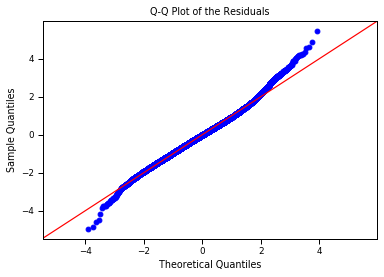

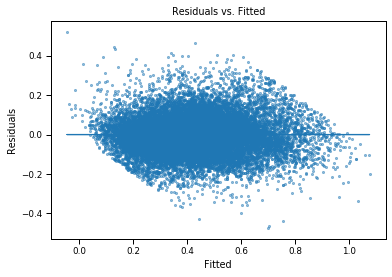

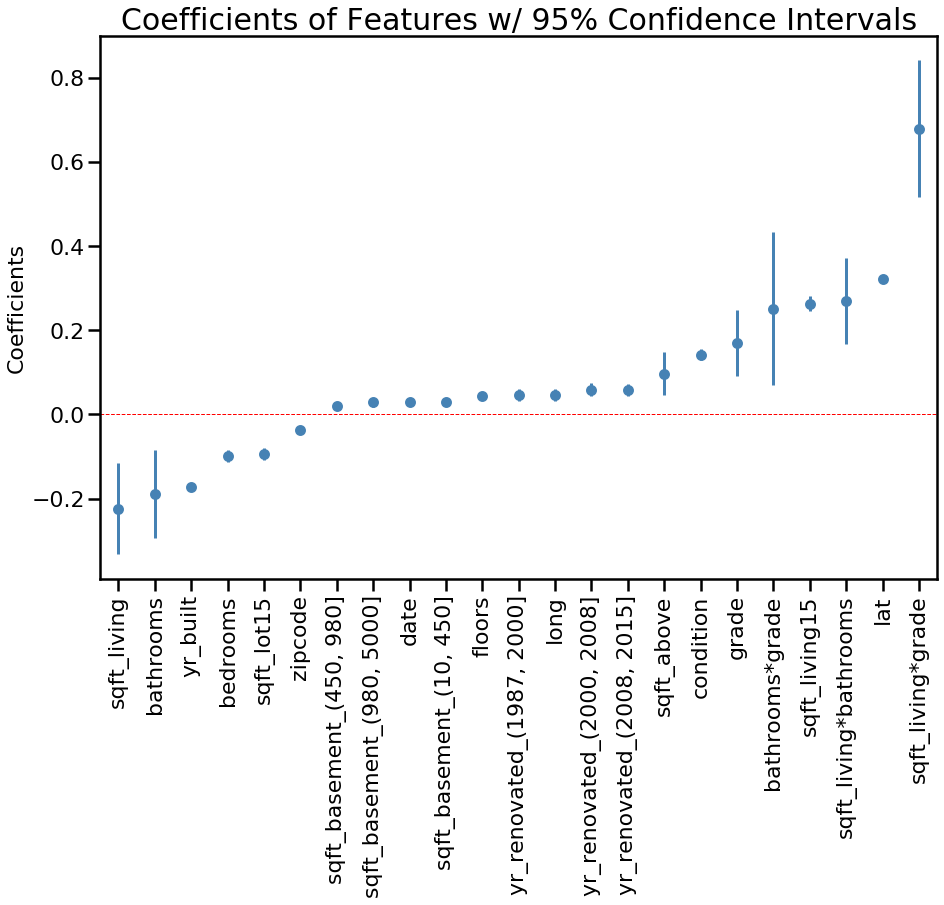

In [59]:
# Plot q-q for Model 3 residuals
qqplot(results3)

# Plot fitted vs. residuals for Model 3 residuals
heterosk(results3)

# Plot coefficients w/95% confidence intervals for Model 3
coefplot(results3)

We can see our top 3 interactions are the front runners here. Lat and sqft_living15 represent neighborhood effects, as they represent latitude and mean square feet of living space (basement included) of the nearest 15 neighbors. 

In future research it would be good to do a neighborhood analysis, as finding a lower priced perhaps lower condition or grade yet large home on the fringe or inside of a nicer neighborhood and upgrading it would be the best way to increase the home's value or selling price. 

Another observation to note here is that the confidence intervals for each interaction here as well as the features that make them up got a lot larger. Our model with just the top interaction has much smaller confidence intervals.  

## Model 4: Exlude Basement

Since sqft_living is inclusive of the basement and sqft_above is the square footage of the home not including the basement, I'm going to test removing the basement features as these data may be rendundant. 

In [60]:
# Get the column headers for the basement binned/one-hot encoded variables
final.head()

,const,"sqft_basement_(10, 450]","sqft_basement_(450, 980]","sqft_basement_(980, 5000]","yr_renovated_(1987, 2000]","yr_renovated_(2000, 2008]","yr_renovated_(2008, 2015]",date,sqft_living,lat,...,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,zipcode,sqft_living*grade,bathrooms*grade,sqft_living*bathrooms
0,1.0,0,0,0,0,0,0,0.420577,0.383390,0.573100,...,0.682606,0.577833,0.386791,0.485598,0.452896,0.332244,0.894035,0.221536,0.147901,0.098132
1,1.0,1,0,0,1,0,0,0.566732,0.640707,0.909499,...,0.682606,0.577833,0.589968,0.450745,0.539649,0.378617,0.626499,0.370222,0.320934,0.355855
2,1.0,0,0,0,0,0,0,0.766714,0.242275,0.936533,...,0.682606,0.472707,0.244424,0.293018,0.717562,0.386904,0.136483,0.114525,0.120993,0.062012
3,1.0,0,1,0,0,0,0,0.566732,0.551134,0.588526,...,1.000000,0.577833,0.347863,0.572419,0.458435,0.313452,0.682037,0.318463,0.382318,0.364653
4,1.0,0,0,0,0,0,0,0.748768,0.500176,0.742607,...,0.682606,0.668898,0.504613,0.761879,0.563223,0.375855,0.368922,0.334566,0.342419,0.256048


In [61]:
# Remove basement features
final = final.drop(['sqft_basement_(10, 450]','sqft_basement_(450, 980]','sqft_basement_(980, 5000]'],axis=1)

In [62]:
# Build Model 4

final_const = sm.add_constant(final)
model = sm.OLS(y,final_const)
results4 = model.fit()

# MSE of the residuals
print(f"MSE: {results4.mse_resid}")

results4.summary()

MSE: 0.009168336684949182


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     3061.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        15:57:52   Log-Likelihood:                 19241.
No. Observations:               20744   AIC:                        -3.844e+04
Df Residuals:                   20723   BIC:                        -3.827e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.2361      0.019    -12.590      0.000      -0.273      -0.199
yr_renovated_(1987, 2000]     0.0460      0.007      6.500      0.000       0.032       0.060
yr_renovated_(2000, 2008]     0.0567      0.008      7.460      0.000       0.042       0.072
yr_renovated_(2008, 2015]     0.0567      0.008      7.488      0.000       0.042       0.072
date                          0.0292      0.002     12.698      0.000       0.025       0.034
sqft_living                  -0.0800      0.051     -1.577      0.115      -0.179       0.019
lat                           0.3230      0.003     99.684      0.000       0.317       0.329
long                          0.0509      0.008      6.539      0.000       0.036       0.066
bedrooms                     -0.1017      0.008    -13.023      0.000      -0.117      -0.086
bathrooms                    -0.2152      0.054     -4.021      0.000      -0.320      -0.110
floors                        0.0427      0.004     11.352      0.000       0.035       0.050
condition                     0.1379      0.007     20.821      0.000       0.125       0.151
grade                         0.1761      0.040      4.433      0.000       0.098       0.254
sqft_above                   -0.0352      0.012     -2.820      0.005      -0.060      -0.011
yr_built                     -0.1729      0.004    -43.108      0.000      -0.181      -0.165
sqft_living15                 0.2637      0.009     28.446      0.000       0.246       0.282
sqft_lot15                   -0.0997      0.008    -13.286      0.000      -0.114      -0.085
zipcode                      -0.0367      0.003    -11.577      0.000      -0.043      -0.030
sqft_living*grade             0.6473      0.083      7.805      0.000       0.485       0.810
bathrooms*grade               0.2930      0.092      3.176      0.001       0.112       0.474
sqft_living*bathrooms         0.2775      0.051      5.436      0.000       0.177       0.378
==============================================================================
Omnibus:                      420.624   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              664.509
Skew:                           0.204   Prob(JB):                    5.06e-145
Kurtosis:                       3.776   Cond. No.                         475.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The time has finally come, when sqft_living is no longer significant. (It's multicollinear and also interacting with some other features, so I'm suprised it lasted this long.) Let's go ahead and remove it. 

In [63]:
# Drop 'sqft_living' 
final = final.drop(['sqft_living'], axis=1)

In [64]:
# Build Model 4b

final_const = sm.add_constant(final)
model = sm.OLS(y,final_const)
results4b = model.fit()

# MSE of the residuals
print(f"MSE: {results4b.mse_resid}")

results4b.summary()

MSE: 0.009168994820416016


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     3222.
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        15:57:53   Log-Likelihood:                 19240.
No. Observations:               20744   AIC:                        -3.844e+04
Df Residuals:                   20724   BIC:                        -3.828e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.2407      0.019    -12.987      0.000      -0.277      -0.204
yr_renovated_(1987, 2000]     0.0459      0.007      6.482      0.000       0.032       0.060
yr_renovated_(2000, 2008]     0.0566      0.008      7.445      0.000       0.042       0.071
yr_renovated_(2008, 2015]     0.0567      0.008      7.488      0.000       0.042       0.072
date                          0.0293      0.002     12.699      0.000       0.025       0.034
lat                           0.3230      0.003     99.668      0.000       0.317       0.329
long                          0.0506      0.008      6.508      0.000       0.035       0.066
bedrooms                     -0.1037      0.008    -13.464      0.000      -0.119      -0.089
bathrooms                    -0.2817      0.033     -8.522      0.000      -0.346      -0.217
floors                        0.0426      0.004     11.314      0.000       0.035       0.050
condition                     0.1379      0.007     20.808      0.000       0.125       0.151
grade                         0.1769      0.040      4.452      0.000       0.099       0.255
sqft_above                   -0.0363      0.012     -2.913      0.004      -0.061      -0.012
yr_built                     -0.1731      0.004    -43.172      0.000      -0.181      -0.165
sqft_living15                 0.2641      0.009     28.499      0.000       0.246       0.282
sqft_lot15                   -0.0989      0.007    -13.210      0.000      -0.114      -0.084
zipcode                      -0.0367      0.003    -11.581      0.000      -0.043      -0.031
sqft_living*grade             0.5360      0.044     12.310      0.000       0.451       0.621
bathrooms*grade               0.4124      0.053      7.830      0.000       0.309       0.516
sqft_living*bathrooms         0.2629      0.050      5.236      0.000       0.164       0.361
==============================================================================
Omnibus:                      416.496   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              657.489
Skew:                           0.203   Prob(JB):                    1.69e-143
Kurtosis:                       3.772   Cond. No.                         269.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We know the drill by now. Our residuals plots for normality and heteroskedasticity checks and insights from our coefficients.

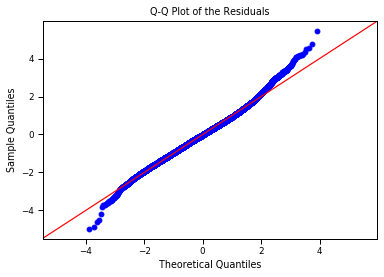

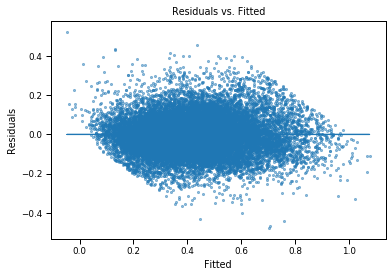

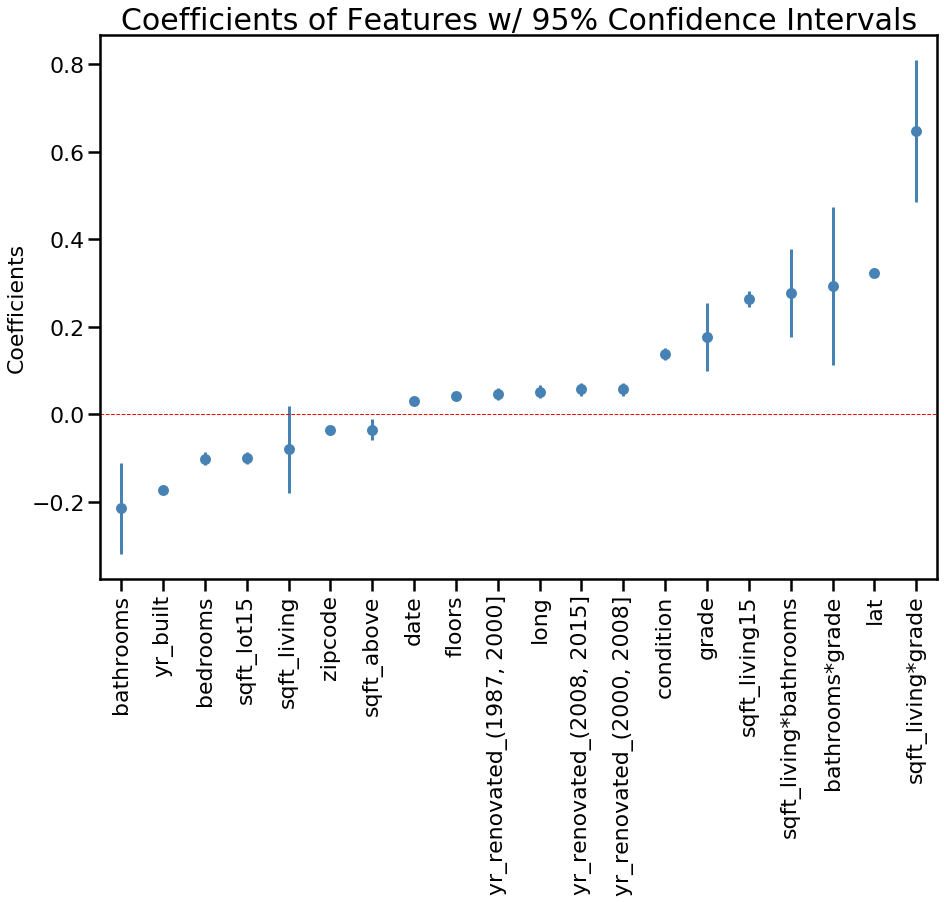

In [65]:
# Plot q-q for Model 4 residuals
qqplot(results4)

# Plot fitted vs. residuals for Model 4 residuals
heterosk(results4)

# Plot coefficients w/95% confidence intervals for Model 4
coefplot(results4)

Model 2 is still our best performing model. So we will stick with that one. That being said, we can still see our top 3 front runners along with the neighborhood effects. Cool. 

# Conclusion

Model 2 with all significant features and the top interaction was our best performing model. Those confidence intervals were tight. 

As for interpretation, we can see the top predicting feature or the feature with the greatest impact on price is the interaction of square feet of living space and grade. 

This is followed by latitude and average square feet of the 15 nearest neighbors, which indicates a neighborhood effect on a home's sale price. This makes sense as this is a key indicator in home selling and buying in real estate e.g. what similar homes in the neighborhood sold for. 

# Recommendations

We have seen the impact grade alone has on the sale price of a home, and when grade is combined with the square feet of living space (including basement if present) it has the greatest impact on sale price of a home.

For this reason, along with the neighborhood effect, I would recommend buying a lower grade home with comparable square feet to its neighborhood and upgrade it to a higher grade. The higher the grade the higher the selling price, yet take into account the neighborhood. How nice of a neighborhood is it? How much are the nicest homes in that neighborhood selling for? 

This leads us to further research. 

- Note: the King County grading scale referenced in this analysis can be found at https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r. 

# Further Research

For further research I would recommend doing a neighborhood analysis with a map to gain an understanding of the different neighborhoods in King County; and their respective home price ranges, sizes, grades and conditions. This will allow the strategy outlined above to be applied most effectively.

# Thank you!

I hope you enjoyed and gained insights from this notebook. Feel free to contact me with any questions at jlforrestbaldini@gmail.com.